# 1. Dataset & Data exploration 

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import nltk
import spacy
import string
import re
import warnings

from nltk.corpus import stopwords
from nltk.collocations import *
from collections import Counter
from nltk.stem import porter
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('genesis')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
stemmer = porter.PorterStemmer()

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

nlp = spacy.load("en_core_web_sm")

nltk.download('punkt')
nltk.download('brown')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

## Importing the dataset

In [2]:
# Importing the dataset
url = 'https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/Digital_Music_5.json?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q'
df_raw = pd.read_json(url)
full_df = pd.DataFrame.from_records(df_raw['data'])


In [3]:
full_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


## exploration 

In [4]:
full_df['overall'].describe()

count    169781.000000
mean          4.700019
std           0.713420
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [5]:
#Number of reviews
print('- Number of reviews:', len(full_df))

#Number of different products reviewed
print('- Number of different products reviewed: ', len(full_df.asin.unique()))

#Number of people who reviewed
print('- Number of people who reviewed: ', len(full_df.reviewerID.unique()))

#Reviews range and average
print('- max rating: ', full_df.overall.max())
print('- min rating: ', full_df.overall.min())
print('- avg rating: ', full_df.overall.mean())

#Time range
start = pd.to_datetime(full_df['unixReviewTime'],unit='s').min().date()
end = pd.to_datetime(full_df['unixReviewTime'],unit='s').max().date()

print('- First review: ', start)
print('- Last review: ', end)


- Number of reviews: 169781
- Number of different products reviewed:  11797
- Number of people who reviewed:  16566
- max rating:  5.0
- min rating:  1.0
- avg rating:  4.700019436803883
- First review:  1998-07-09
- Last review:  2018-09-26


Distribution of rating

Text(0, 0.5, 'reiew counts')

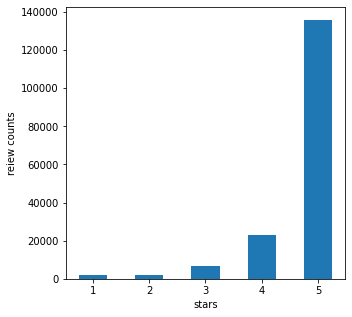

In [6]:
ax = full_df.overall.hist(grid=False, bins=np.arange(0.75,5.75,0.5),figsize=(5,5))

ax.set_xlabel("stars")
ax.set_ylabel("reiew counts")

Distribution of reviews per product

In [7]:
reviews_per_asin = full_df.asin.value_counts()
reviews_per_asin

B00CZF8B68    574
B00BWGHIHY    316
B00136J7ZE    294
B00EH49FRE    283
B00136NUG6    262
             ... 
B000W1S2WU      1
B00125MGQI      1
B001QET6G8      1
B001664ADA      1
B00138APMQ      1
Name: asin, Length: 11797, dtype: int64

reviews product-counts
5      2072
6      1506
7      1050
8       824
9       684
       ... 
146       1
147       1
148       1
152       1
574       1
Name: asin, Length: 163, dtype: int64


Text(0, 0.5, 'product counts')

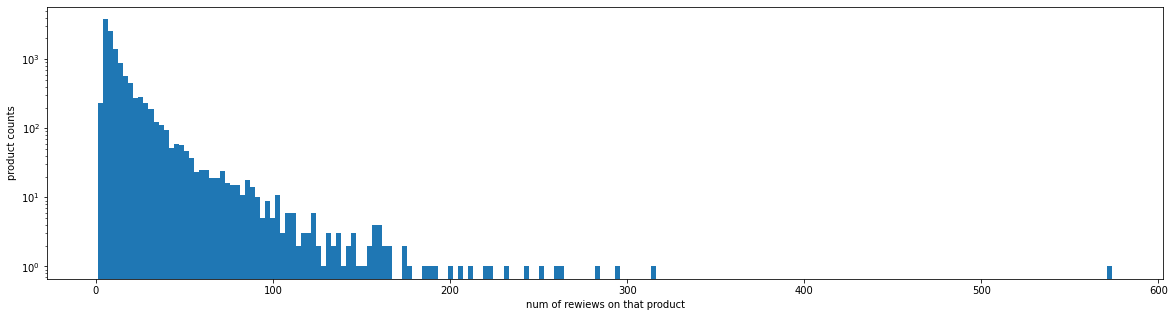

In [8]:
print("reviews product-counts")
print(reviews_per_asin.value_counts())

ax = reviews_per_asin.hist(log=True,grid=False,bins=200,figsize=(20,5))
ax.set_xlabel("num of rewiews on that product")
ax.set_ylabel("product counts")

Distribution of reviews per user

In [9]:
reviews_per_user = full_df.reviewerID.value_counts()
reviews_per_user

A3W4D8XOGLWUN5    791
A2H3JURQZOHVMB    314
A36EDWL4F3AASU    223
A165P3MOJV3OVZ    219
AVKHYC2D7MD56     214
                 ... 
A2VWLNEBMW4ITQ      2
A2M4D98UYXMUZE      2
A518S7KT78N51       2
A25HR6FTWBQ2NZ      1
A70WPHE33U5B        1
Name: reviewerID, Length: 16566, dtype: int64

reviews user-counts
5      4559
6      2798
7      1927
8      1288
9       974
       ... 
101       1
102       1
314       1
106       1
791       1
Name: reviewerID, Length: 125, dtype: int64


Text(0, 0.5, 'user counts')

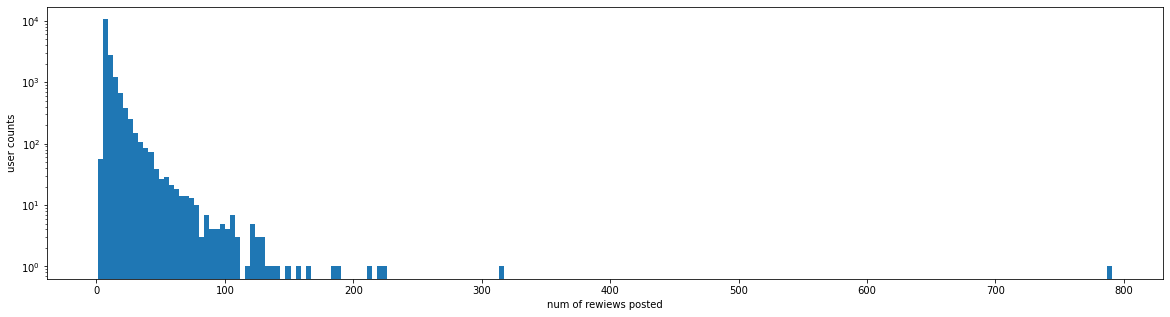

In [10]:
print("reviews user-counts")
print(reviews_per_user.value_counts())

ax = reviews_per_user.hist(log=True,grid=False,bins=200,figsize=(20,5))
ax.set_xlabel("num of rewiews posted")
ax.set_ylabel("user counts")


Shape of the dataset: (169781, 12)


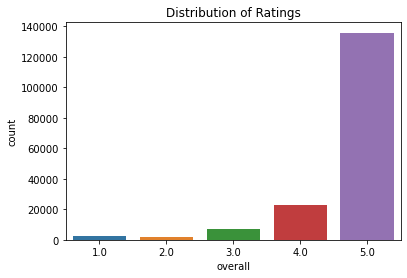

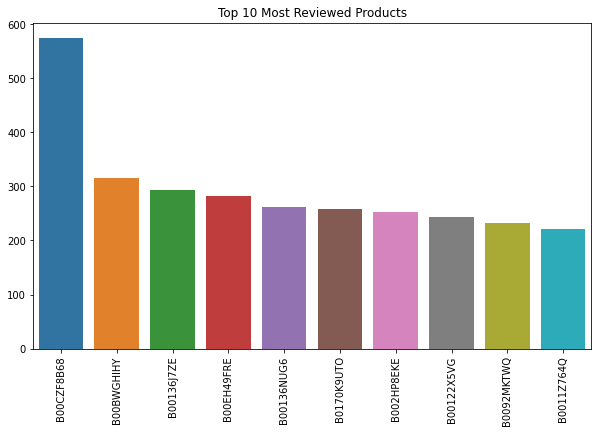

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check the shape of the dataset
print("Shape of the dataset:", full_df.shape)

# Check the distribution of ratings
sns.countplot(x='overall', data=full_df)
plt.title("Distribution of Ratings")
plt.show()

# Check the top 10 most reviewed products
top_products = full_df['asin'].value_counts().nlargest(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title("Top 10 Most Reviewed Products")
plt.xticks(rotation=90)
plt.show()

# 2. Text basic pre-processing

## (Col:'Sentiment') based on the value of “rating of the product”:<br/> i. Ratings 4,5: Positive <br/>ii. Rating 3: Neutral <br/>iii. Ratings 1,2: Negative


In [12]:
full_df['Sentiment'] = np.where((full_df['overall'] > 3), 'Positive', 
                          np.where((full_df['overall'] < 3), 'Negative', 'Neutral'))
full_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Sentiment
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN,Positive
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN,Positive
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN,Positive
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN,Positive
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN,Positive


In [13]:
full_df['Sentiment'].value_counts() #how can we balance this data?

Positive    158985
Neutral       6792
Negative      4004
Name: Sentiment, dtype: int64

## columns selection

In [14]:
full_df['verified'].value_counts()

True     148944
False     20837
Name: verified, dtype: int64

In [15]:
#full_df.info()

In [16]:
cols = ['reviewText','summary']
full_df['NewReview'] = full_df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
full_df['NewReview'] = full_df['NewReview'].astype(str)

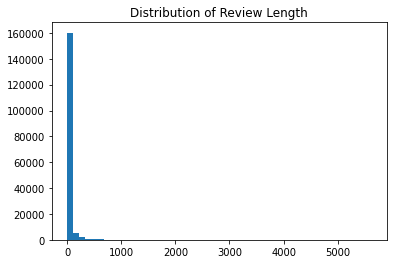

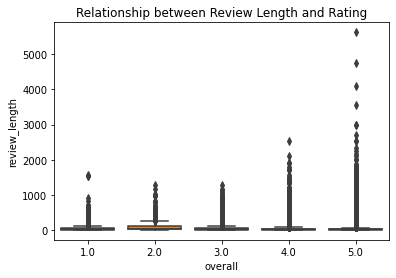

In [17]:
# Check the length of reviews
full_df['review_length'] = full_df['NewReview'].apply(lambda x: len(x.split()))
plt.hist(full_df['review_length'], bins=50)
plt.title("Distribution of Review Length")
plt.show()

# Check the relationship between review length and rating
sns.boxplot(x='overall', y='review_length', data=full_df)
plt.title("Relationship between Review Length and Rating")
plt.show()

In [18]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         169781 non-null  float64
 1   vote            7611 non-null    object 
 2   verified        169781 non-null  bool   
 3   reviewTime      169781 non-null  object 
 4   reviewerID      169781 non-null  object 
 5   asin            169781 non-null  object 
 6   style           157989 non-null  object 
 7   reviewerName    169776 non-null  object 
 8   reviewText      169623 non-null  object 
 9   summary         169745 non-null  object 
 10  unixReviewTime  169781 non-null  int64  
 11  image           182 non-null     object 
 12  Sentiment       169781 non-null  object 
 13  NewReview       169781 non-null  object 
 14  review_length   169781 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(11)
memory usage: 18.3+ MB


In [19]:
full_df.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Sentiment,NewReview,review_length
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN,Positive,"This is awesome to listen to, A must-have for ...",25
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN,Positive,bien Five Stars,3


In [20]:
#reviewerID will be useful later to see if they are outliers or not
music_review_df = full_df.drop(columns=['vote','reviewerID','image','reviewTime','reviewerID','style','reviewerName','unixReviewTime','reviewText','summary'])

In [21]:
music_review_df.head(2)

,overall,verified,asin,Sentiment,NewReview,review_length
0,5.0,True,3426958910,Positive,"This is awesome to listen to, A must-have for ...",25
1,5.0,True,3426958910,Positive,bien Five Stars,3


In [22]:
music_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   overall        169781 non-null  float64
 1   verified       169781 non-null  bool   
 2   asin           169781 non-null  object 
 3   Sentiment      169781 non-null  object 
 4   NewReview      169781 non-null  object 
 5   review_length  169781 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 6.6+ MB


## sampling 

In [23]:
n_samples = 1000 # @param {type:"integer"}

#Getting the reviews from the dataset
sample_df=music_review_df.sample(n = n_samples)
# reviews = [str(review) for review in sample_df.NewReview.values] # moved

#sample = reviews[:1000] #To reduce the runtime

In [24]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 133839 to 15588
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   overall        1000 non-null   float64
 1   verified       1000 non-null   bool   
 2   asin           1000 non-null   object 
 3   Sentiment      1000 non-null   object 
 4   NewReview      1000 non-null   object 
 5   review_length  1000 non-null   int64  
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 47.9+ KB


In [25]:
sample_df.head()

,overall,verified,asin,Sentiment,NewReview,review_length
133839,5.0,True,B00136LMJ8,Positive,Great song. Five Stars,4
132014,5.0,True,B0012486CM,Positive,What can I say this the Music I grew up on. Tr...,19
165975,4.0,True,B00QNJW6L8,Positive,It starts with pain.. followed by hate. Story ...,14
47346,5.0,True,B00137MPOI,Positive,5* Five Stars,3
138675,5.0,True,B00137X9O8,Positive,Whitney Houston's version of this song is the ...,45


# 3. Text representation (approaches in course module 2)

## Tokenisation, Lemmatization, Stemming, pos, entities

In [26]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Convert text to lowercase
sample_df['NewReview'] = sample_df['NewReview'].str.lower()

# Remove URLs
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: re.sub(r'http\S+', '', x))

# Remove HTML tags
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: re.sub(r'<.*?>', '', x))

# Remove punctuation
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [27]:

reviews = [str(review) for review in sample_df.NewReview.values]


In [28]:
# Tokenize the text
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: word_tokenize(x))

# Remove stopwords and perform stemming
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: [porter.stem(word) for word in x if word not in stop_words])

# Join the stemmed words back into a single string
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: ' '.join(x))


In [29]:
#Tokenisation
tokens = [[token.text for token in nlp(sentence)] for sentence in reviews]

#Lemmatization
lemmas = [[token.lemma_ if token.lemma_ != "-PRON-" else token.lower_ for token in nlp(sentence)] for sentence in reviews]

#Stemming
stems = [[stemmer.stem(token) for token in sentence] for sentence in tokens]

#Getting pos
pos = [nltk.pos_tag(token) for token in tokens]

#Getting entities
entities = [[[ent.text, ent.label_] for ent in nlp(sentence).ents] for sentence in reviews] 

In [30]:
#Most common people
people = [person[0] for person in [item for sublist in entities for item in sublist if item[1]=='PERSON']]
print('5 most common people: ', Counter(people).most_common(10))

#Most common music
music = [person[0] for person in [item for sublist in entities for item in sublist if item[1]=='WORK_OF_ART']]
print('5 most common work of art: ', Counter(music).most_common(10))

5 most common people:  [('chris cornell', 5), ('taylor', 5), ('johann sebastian bach', 5), ('chris', 4), ('hamilton', 4), ('antonin dvorak', 4), ('george strait', 3), ('michael jackson', 3), ('matt smith', 3), ('bobby fuller', 2)]
5 most common work of art:  [('peer gynt', 2)]


In [31]:
#Taking the stems or the lemmas 
ptext = [' '.join(word) for word in lemmas]

#Converting to lowercase
ptext = [review.lower() for review in ptext]

#Removing numbers
ptext = [re.sub(r'\d+', '', review) for review in ptext]

#Removing punctuation
ptext = [re.sub(r'[^\w\s]',' ',review) for review in ptext]
ptext = [re.sub(' +', ' ', review) for review in ptext]
ptext = [re.sub('_', '', review) for review in ptext]

#Removing leading and trailing whitespaces
ptext = [review.strip() for review in ptext]

#Removing stopwords
ptext = [' '.join([word for word in review.split() if word not in stop_words]) for review in ptext]

In [32]:
frame = {'Original': reviews, 
        'After Proprocessing': ptext}

pd.DataFrame.from_dict(frame)


,Original,After Proprocessing
0,great song five stars,great song five star
1,what can i say this the music i grew up on try...,say music grow try like try like
2,it starts with pain followed by hate story of ...,start pain follow hate story life speak
3,5 five stars,five star
4,whitney houstons version of this song is the b...,whitney houston version song good version come...
...,...,...
995,good compilation four stars,good compilation four star
996,my cousin sings this every week when we go out...,cousin sing every week go karaoke great comfor...
997,good product fast delivery five stars,good product fast delivery five star
998,elva ruby connes miller was truly one of the m...,elva ruby conne miller truly one amazing voice...


In [33]:
#Number of words
print('Number of words:')

bef = len(re.findall(r'\w+', ' '.join(reviews)))
aft = len(re.findall(r'\w+', ' '.join(ptext)))

print('- Before preprocessing: ', bef )
print('- After preprocessing: ', aft )
print()

#Average review length
print('Average review length:')

bef_a = bef/n_samples
aft_a = aft/n_samples

print('- Before preprocessing: ', bef_a )
print('- After preprocessing: ', aft_a )
print()

#Punctuation
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
punct_b = 0
for i in sample_df:
    punct_b += count(i,set(string.punctuation))
punct_a = 0
for i in ptext:
    punct_a += count(i,set(string.punctuation))
    
print('Number of punctuation character:')
print('- Before preprocessing: ', punct_b)
print('- After preprocessing: ', punct_a)
print()


Number of words:
- Before preprocessing:  34924
- After preprocessing:  18715

Average review length:
- Before preprocessing:  34.924
- After preprocessing:  18.715

Number of punctuation character:
- Before preprocessing:  1
- After preprocessing:  0



## glove

In [34]:
from keras.utils import get_file

dir1 = get_file(origin="https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/glove.6B.100d.zip.001?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q")
dir2 = get_file(origin="https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/glove.6B.100d.zip.002?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q")

dir1

38726106/38726106 [==============================] - 0s 0us/step


'/root/.keras/datasets/glove.6B.100d.zip.001'

In [39]:
### for Colab!!! change path if not running in Colab 

!cat /root/.keras/datasets/glove.6B.100d.zip* > /root/.keras/datasets/glove.6B.100d.zip

!unzip  /root/.keras/datasets/glove.6B.100d.zip 

Archive:  /root/.keras/datasets/glove.6B.100d.zip
  inflating: glove.6B.100d.txt       


In [36]:
EMBEDDING_DIM = 100 # @param {type:"integer"}

In [40]:

# first, build index mapping words in the embeddings set
# to their embedding vector

embeddings_index = {}
#C:\Courses_cent\COMP 262\practical-nlp-master\Ch4\Glove6B
#with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf-8") as f:
with open("glove.6B.100d.txt", encoding ="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))

def get_embeddings(word):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        # words not found in embedding index will be all-zeros.
        embedding_vector = np.zeros(shape=(EMBEDDING_DIM, ))
    return embedding_vector

Found 400000 word vectors in Glove embeddings.


In [41]:
embeded = [[get_embeddings(word) for word in review.split() ] for review in ptext]


In [43]:
frame = {'Original': reviews, 
        'After embedding': embeded}

pd.DataFrame.from_dict(frame)


,Original,After embedding
0,great song five stars,"[[-0.013786, 0.38216, 0.53236, 0.15261, -0.296..."
1,what can i say this the music i grew up on try...,"[[-0.091682, 0.58105, 0.40477, -0.41979, -0.85..."
2,it starts with pain followed by hate story of ...,"[[0.23336, 0.16042, 0.050714, -0.0016366, -0.4..."
3,5 five stars,"[[0.062482, 0.47966, 0.11041, -0.32933, 0.4811..."
4,whitney houstons version of this song is the b...,"[[0.1347, 0.55149, -0.20511, -0.69281, 0.42393..."
...,...,...
995,good compilation four stars,"[[-0.030769, 0.11993, 0.53909, -0.43696, -0.73..."
996,my cousin sings this every week when we go out...,"[[0.53674, -0.42193, 0.41404, -0.13696, 0.0923..."
997,good product fast delivery five stars,"[[-0.030769, 0.11993, 0.53909, -0.43696, -0.73..."
998,elva ruby connes miller was truly one of the m...,"[[0.026681, -0.060791, 0.011155, 0.028152, 0.0..."



# 4. Modeling 

## VADR sentiment

In [44]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [45]:
!pip install --upgrade vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 6.8 MB/s eta 0:00:00


In [46]:
nltk.download('sentiwordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [47]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [48]:
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0 :
        result = 'Positive'
 
    elif sentiment_dict['compound'] < - 0.07 :
        result = 'negative'
 
    else :
        result = 'Neurtral'
    return result, sentiment_dict



    # print("Overall sentiment dictionary is : ", sentiment_dict)
    # print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    # print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    # print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
    # print("Sentence Overall Rated As", end = " ")
 
    # # decide sentiment as positive, negative and neutral
    # if sentiment_dict['compound'] >= 0.05 :
    #     print("Positive")
 
    # elif sentiment_dict['compound'] <= - 0.05 :
    #     print("Negative")
 
    # else :
    #     print("Neutral")

In [49]:
sample_df['NewReview']

133839                                 great song five star
132014         say music grew tri youll like tri youll like
165975              start pain follow hate stori life speak
47346                                           5 five star
138675    whitney houston version song best version ive ...
                                ...                        
87648                                 good compil four star
29173     cousin sing everi week go karaok great comfort...
99609                  good product fast deliveri five star
9240      elva rubi conn miller truli one amaz voic twen...
15588     first heard song niec wed felt love glad saw s...
Name: NewReview, Length: 1000, dtype: object

In [50]:
sample_df.reset_index(inplace=True)

In [51]:
# sentiment_scores(sample_df['NewReview'][0])


In [52]:
# from nltk.corpus import sentiwordnet as swn
# breakdown = swn.senti_synset('breakdown.n.03')

In [53]:
# list(swn.senti_synsets('slow'))

In [54]:
sample_df['SentimentScores'] = sample_df['NewReview'].apply(lambda x: sentiment_scores(x))
sample_df[['PredictedSentiment','SentimentDict']] = sample_df['SentimentScores'].apply(lambda x: pd.Series([x[0], x[1]]))

In [55]:
sample_df['SentimentScores'][10] , sample_df['Sentiment'][10], sample_df['NewReview'][10]

(('Positive', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 'Positive',
 'awesom song five star')

In [56]:
# Define a function to compute the accuracy
def compute_accuracy(row):
    if row['PredictedSentiment'] == row['Sentiment']:
        return 1
    else:
        return 0

# Apply the function to each row and save the results to a new column
sample_df['accuracy'] = sample_df.apply(compute_accuracy, axis=1)

# Compute the overall accuracy
accuracy = sample_df['accuracy'].sum() / len(sample_df)
print(f"Overall accuracy: {accuracy}")

Overall accuracy: 0.914


## Text blob

In [57]:
from textblob import TextBlob

In [58]:
wiki = TextBlob(sample_df['NewReview'][0])

In [59]:
import nltk
nltk.download('punkt')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [60]:
#Parts of Speech
wiki.tags

[('great', 'JJ'), ('song', 'NN'), ('five', 'CD'), ('star', 'NN')]

In [61]:
wiki.noun_phrases

WordList(['great song'])

In [62]:
wiki.sentiment

Sentiment(polarity=0.8, subjectivity=0.75)

In [63]:
wiki.words

WordList(['great', 'song', 'five', 'star'])

In [64]:
df_textblob = sample_df

In [65]:
df_textblob['sentiment'] = sample_df['NewReview'].apply(lambda tweet: TextBlob(tweet).sentiment)

In [66]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

df_textblob['sentiment'] = sample_df['NewReview'].apply(sentiment_calc)

In [67]:
df_textblob

,index,overall,verified,asin,Sentiment,NewReview,review_length,SentimentScores,PredictedSentiment,SentimentDict,accuracy,sentiment
0,133839,5.0,True,B00136LMJ8,Positive,great song five star,4,"(Positive, {'neg': 0.0, 'neu': 0.423, 'pos': 0...",Positive,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...",1,"(0.8, 0.75)"
1,132014,5.0,True,B0012486CM,Positive,say music grew tri youll like tri youll like,19,"(Positive, {'neg': 0.0, 'neu': 0.583, 'pos': 0...",Positive,"{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'comp...",1,"(0.0, 0.0)"
2,165975,4.0,True,B00QNJW6L8,Positive,start pain follow hate stori life speak,14,"(negative, {'neg': 0.583, 'neu': 0.417, 'pos':...",negative,"{'neg': 0.583, 'neu': 0.417, 'pos': 0.0, 'comp...",0,"(-0.8, 0.9)"
3,47346,5.0,True,B00137MPOI,Positive,5 five star,3,"(Positive, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0...",Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,"(0.0, 0.0)"
4,138675,5.0,True,B00137X9O8,Positive,whitney houston version song best version ive ...,45,"(Positive, {'neg': 0.0, 'neu': 0.514, 'pos': 0...",Positive,"{'neg': 0.0, 'neu': 0.514, 'pos': 0.486, 'comp...",1,"(0.62, 0.5399999999999999)"
...,...,...,...,...,...,...,...,...,...,...,...,...
995,87648,4.0,True,B00C6MPXUM,Positive,good compil four star,4,"(Positive, {'neg': 0.0, 'neu': 0.508, 'pos': 0...",Positive,"{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",1,"(0.7, 0.6000000000000001)"
996,29173,5.0,False,B000VRQQRS,Positive,cousin sing everi week go karaok great comfort...,28,"(Positive, {'neg': 0.155, 'neu': 0.442, 'pos':...",Positive,"{'neg': 0.155, 'neu': 0.442, 'pos': 0.403, 'co...",1,"(0.0500000000000001, 0.7083333333333333)"
997,99609,5.0,True,B00JRZP3EC,Positive,good product fast deliveri five star,7,"(Positive, {'neg': 0.0, 'neu': 0.633, 'pos': 0...",Positive,"{'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...",1,"(0.44999999999999996, 0.6000000000000001)"
998,9240,5.0,True,B000WAJIE2,Positive,elva rubi conn miller truli one amaz voic twen...,233,"(Positive, {'neg': 0.056, 'neu': 0.715, 'pos':...",Positive,"{'neg': 0.056, 'neu': 0.715, 'pos': 0.228, 'co...",1,"(0.2590909090909091, 0.3959595959595959)"


## Word Cloud

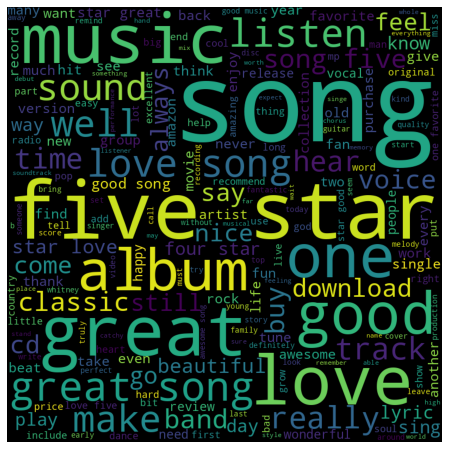

In [68]:
#Code take from GFG to generate Word Cloud

comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in ptext:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

#Generate word cloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
#Plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
 
plt.show()